In [21]:
#imports needed for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, r2_score

In [22]:
#loading clean data from csv and splitting it

#loading the data saved in Notebook 01
df = pd.read_csv('../data/bodyfat_processed.csv')

#separate Features and Target
X = df.drop(columns=['class'])    #'class' column is bodyfat
y = df['class']

# splitting the datat 
# (CRITICAL: Use the same random_state=42 as before!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling the features using roubust scaler,based on median, because we have a lot of outliers ( 21 greater than 3 times sigma)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset loaded. Training set size: {X_train_scaled.shape}")

Dataset loaded. Training set size: (200, 13)


The 5 best predictors are:
['Weight', 'Chest', 'Abdomen', 'Biceps', 'Wrist']


/tmp/ipykernel_2390/2779734615.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ranking', y='Feature', data=feature_ranking, palette='viridis')


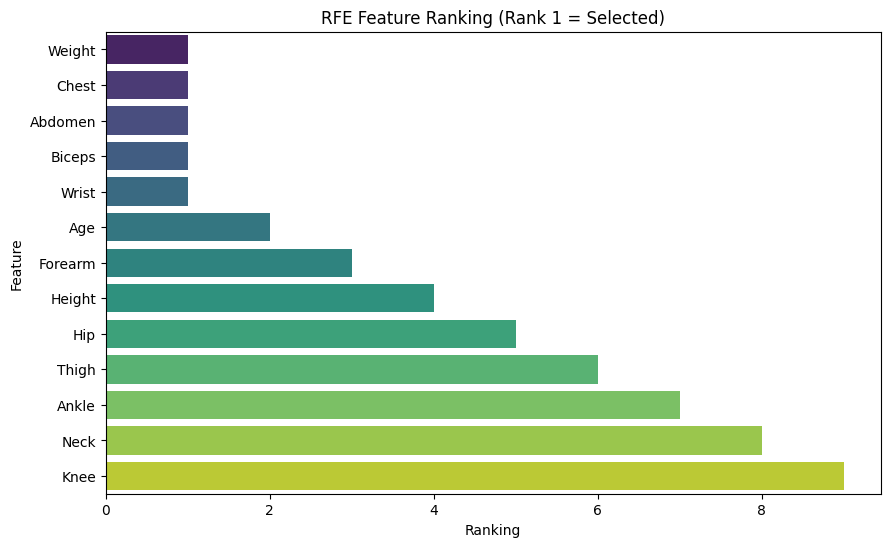

In [23]:
# Attemp 1: Manual Feature Selection (RFE)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# initializing the base model
# linear regression because it's easy to interpret
lr = LinearRegression()

# initializing RFE
# n_features_to_select=5 tells the computer to stop when it finds the best 5
rfe = RFE(estimator=lr, n_features_to_select=5)

# fitting RFE on the SCALED training data
rfe.fit(X_train_scaled, y_train)

# extracting the results
selected_features = X.columns[rfe.support_]
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})

print("The 5 best predictors are:")
print(selected_features.tolist())


# Sort features by ranking (Rank 1 means it was selected)
feature_ranking = feature_ranking.sort_values(by='Ranking')

plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking, palette='viridis')
plt.title("RFE Feature Ranking (Rank 1 = Selected)")
plt.show()

In [24]:
# re-traing a simple model on just the 5 selected features to get their weights
X_train_rfe = X_train_scaled[:, rfe.support_]
lr_final = LinearRegression()
lr_final.fit(X_train_rfe, y_train)

# creating a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_final.coef_
})

# sorting and dipslaying the results
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Coefficients for the Top 5 Features:")
print(coef_df[['Feature', 'Coefficient']])






Coefficients for the Top 5 Features:
   Feature  Coefficient
2  Abdomen    15.309540
0   Weight    -4.694536
4    Wrist    -1.699305
3   Biceps     1.364038
1    Chest    -0.953129


Optimal number of features: 2
The best features are: ['Weight', 'Abdomen']


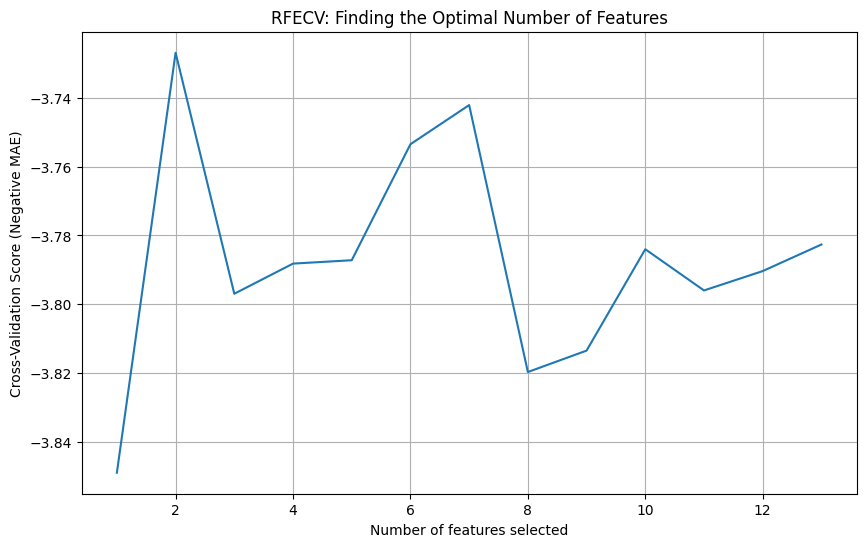

In [25]:
# Attemp 2: Automated Feature Selection (RFECV)
from sklearn.feature_selection import RFECV

# initializing the selector
# cv=5 means 5-fold cross-validation,
# step=1 means one column drops every iteration
# scoring='neg_mean_absolute_error' means we want to minimize the prediction error
selector = RFECV(estimator=lr, step=1, cv=5, scoring='neg_mean_absolute_error')

# fit to the scaled data, using 5 fold cross valiadation
selector.fit(X_train_scaled, y_train)

# 3. Results
print(f"Optimal number of features: {selector.n_features_}")
print(f"The best features are: {X.columns[selector.support_].tolist()}")

# 4. Plotting the results 
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-Validation Score (Negative MAE)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'])
plt.title("RFECV: Finding the Optimal Number of Features")
plt.grid(True)
plt.show()

Full Feature Ranking (Rank 1 = Best):
Feature  Ranking
 Weight        1
Abdomen        1
  Wrist        2
 Biceps        3
  Chest        4
    Age        5
Forearm        6
 Height        7
    Hip        8
  Thigh        9
  Ankle       10
   Neck       11
   Knee       12


/tmp/ipykernel_2390/2320427178.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ranking', y='Feature', data=ranking_df, palette='magma')


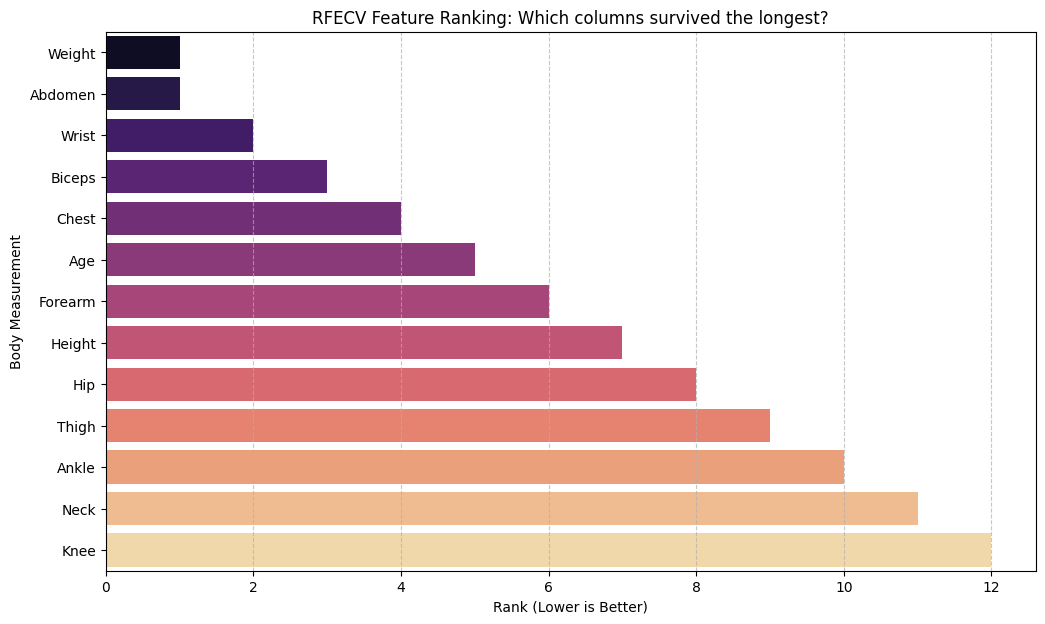

In [26]:
# checking the ranking table of every feature
ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': selector.ranking_
})

# sorting the features so Rank 1 is at the top
ranking_df = ranking_df.sort_values(by='Ranking')

# displaying
print("Full Feature Ranking (Rank 1 = Best):")
print(ranking_df.to_string(index=False))


plt.figure(figsize=(12, 7))
sns.barplot(x='Ranking', y='Feature', data=ranking_df, palette='magma')
plt.title("RFECV Feature Ranking: Which columns survived the longest?")
plt.xlabel("Rank (Lower is Better)")
plt.ylabel("Body Measurement")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [27]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score

# preparing the data using only the ranked features from RFECV
X_train_final = X_train_scaled[:, selector.support_]
X_test_final = X_test_scaled[:, selector.support_]

#alpha is the strength ot the penalty
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.1)
}

# traing and evaluating in a loop
results = []

for name, model in models.items():
    model.fit(X_train_final, y_train)
    predictions = model.predict(X_test_final)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    results.append({"Model": name, "MAE": mae, "R2": r2})

# 4. Display the Leaderboard
performance_df = pd.DataFrame(results).sort_values(by="MAE")
print("Model Comparison Leaderboard:")
print(performance_df)


Model Comparison Leaderboard:
               Model       MAE        R2
0  Linear Regression  3.741315  0.607458
1         Ridge (L2)  3.754403  0.606290
2         Lasso (L1)  3.811011  0.594896


In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# ALL candidate models
configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # No hyperparameters to tune for basic OLS
    },
    "Ridge": {
        "model": Ridge(),
        "params": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    }
}

best_models = {}

# the Tuning & Comparison Loop
for name, config in configs.items():
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X_train_final, y_train)
    
    best_models[name] = {
        "best_estimator": grid.best_estimator_,
        "best_score": -grid.best_score_
    }
    
    # print Alpha if it's not the Linear Regression model
    alpha_info = f", Best Alpha: {grid.best_params_.get('alpha')}" if 'alpha' in grid.best_params_ else ""
    print(f"{name} - CV MAE: {-grid.best_score_:.3f}{alpha_info}")


champion_name = min(best_models, key=lambda x: best_models[x]['best_score']) #model with minimal MAE
final_model = best_models[champion_name]['best_estimator']

print(f"\n🏆 The Final Champion is: {champion_name}")

Linear Regression - CV MAE: 3.603
Ridge - CV MAE: 3.604, Best Alpha: 0.001
Lasso - CV MAE: 3.604, Best Alpha: 0.001

🏆 The Final Champion is: Linear Regression


/tmp/ipykernel_2390/765872625.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mae_scores, palette='viridis')


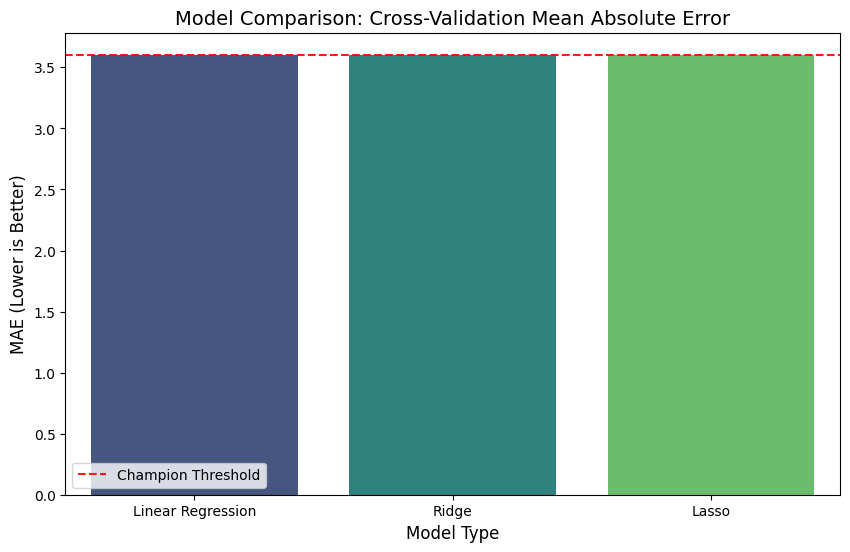

In [29]:
#data for plotting
model_names = list(best_models.keys())
mae_scores = [best_models[name]['best_score'] for name in model_names]


plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=mae_scores, palette='viridis')
plt.axhline(y=min(mae_scores), color='red', linestyle='--', alpha=0.9, label='Champion Threshold')

plt.title('Model Comparison: Cross-Validation Mean Absolute Error', fontsize=14)
plt.ylabel('MAE (Lower is Better)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, r2_score

# predictions on the unseen test data
y_pred = final_model.predict(X_test_final)

# final metrics
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"--- FINAL CHAMPION EVALUATION ({champion_name}) ---")
print(f"Final Test MAE: {final_mae:.3f}")
print(f"Final Test R2: {final_r2:.3f}")

--- FINAL CHAMPION EVALUATION (Linear Regression) ---
Final Test MAE: 3.741
Final Test R2: 0.607


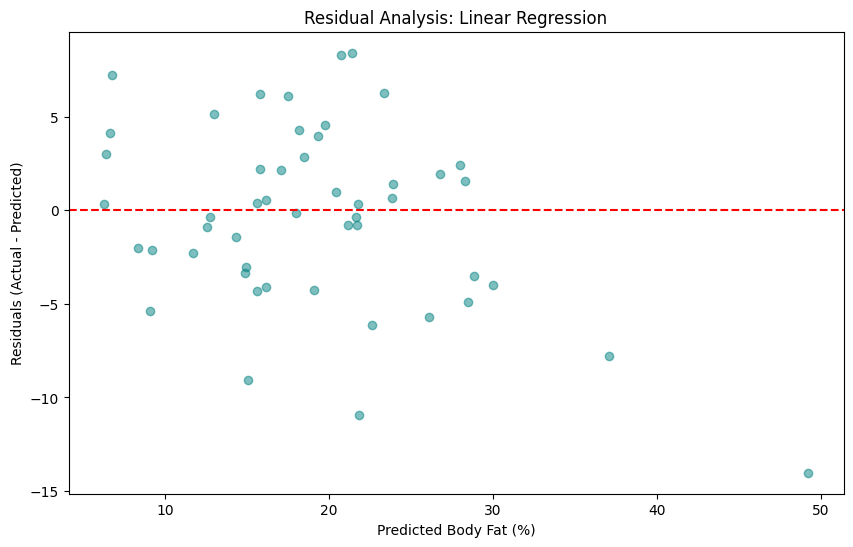

In [31]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Body Fat (%)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Analysis: {champion_name}')
plt.show()

In [36]:
# best features from selector
best_features = X.columns[selector.support_].tolist()

# Refit the scaler on ONLY the best features 

scaler = RobustScaler()
X_train_best = X_train[best_features] only the columns the model uses
scaler.fit(X_train_best) 

def predict_bodyfat_pro(measurements_dict, model, fitted_scaler, feature_names):
    # input to DataFrame
    input_df = pd.DataFrame([measurements_dict])
    
    # reordering columns to ensure they match the 'best_features' list
    input_df = input_df[feature_names]
    
    # transforming using the scaler that now only expects these specific columns
    input_scaled = fitted_scaler.transform(input_df)
    
    # predict using the champion model
    prediction = model.predict(input_scaled)
    return prediction[0]

# --- TEST ---
sample_input = {feat: X[feat].mean() for feat in best_features}
result = predict_bodyfat_pro(sample_input, final_model, scaler, best_features)

print(f"✅ Success! Predicted Body Fat: {result:.2f}%")

✅ Success! Predicted Body Fat: 19.24%


In [39]:
import joblib
import os


# '..' means "go up one level" out of the notebooks folder
models_dir = os.path.join('..', 'models')

# create the directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# save the 3 essential components using the full path
joblib.dump(final_model, os.path.join(models_dir, 'bodyfat_model.pkl'))
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
joblib.dump(best_features, os.path.join(models_dir, 'features.pkl'))

print(f"✅ Success! Files saved to: {os.path.abspath(models_dir)}")

✅ Success! Files saved to: /home/dw/Desktop/bodyfat_ml_project/models
